<a href="https://colab.research.google.com/github/csabot3/liverAItutorial/blob/main/Lesson2_Part1_CT_UNet_Liver_Segmentation_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 2, Part 1: Liver Segmentation with U-Nets for CT Data

Lesson 2 is when we will start actually working with AI models in order to perform segmentation of the liver with CT and MRI data. Since this lesson is a bit long, it has been divided into separate parts for working with CT and MRI data. However, there is considerable similarity between both parts of this lesson.

We will start by importing libraries. We will be importing significantly more outside libraries compared to lesson 1 with FastAI being the main library that we will be using for U-net/AI model development. You can learn more about FastAI by visiting the FastAI website: https://www.fast.ai/

Additionally, the FastAI book which can be experienced via Jupyter notebooks run in Colab is a phenomenal resource for learning AI from a practical perspective: https://github.com/fastai/fastbook

In [1]:
!pip install pydicom #Not in Colab by default
!apt-get -qq install pv #Progress bar, also not in Colab



from IPython.display import display,HTML

#Now we will import several parts of the FastAI library

!pip install fastai --upgrade -q

from fastai.vision.all import *
from fastcore.xtras import Path
from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

import os
import shutil
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from pathlib import Path
import pandas as pd
import glob
import sys

     |████████████████████████████████| 2.0 MB 8.1 MB/s 
Selecting previously unselected package pv.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../archives/pv_1.6.6-1_amd64.deb ...
Unpacking pv (1.6.6-1) ...
Setting up pv (1.6.6-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 188 kB 8.3 MB/s 
     |████████████████████████████████| 60 kB 7.7 MB/s 


Before we get going, we will want to make sure that we have changed Colab to have a GPU accelerated run time. Otherwise, when we say that something will take 2 minutes to run as part of training the U-net model, it might end up taking hours to run on a CPU. We can change to a GPU runtime by selecting Runtime -> Change runtime type, and then selecting GPU hardware accelerator. Let's look at how some code can clarify that we are working with a GPU by investigaging the NVIDIA System Management Interface.

In [2]:
!nvidia-smi

Thu Apr 14 05:46:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#We can look at this in a slightly more sophisticated manner like so
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('We need to change the runtime and select GPU as a hardware accelerator!')
else:
  print(gpu_info)

Thu Apr 14 05:46:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Next we will download the CHAOS dataset: https://chaos.grand-challenge.org/

In [4]:
#Get the CHAOS data hosted on Zenodo - takes approximately 1-2 minutes to download each train and test
!wget -q --show-progress https://zenodo.org/record/3431873/files/CHAOS_Train_Sets.zip?download=1

CHAOS_Train_Sets.zi 100%[===================>] 849.51M  4.63MB/s    in 1m 47s  


If we want the test dataset, we can uncomment the line below by removing the #, but we are not ready for the test dataset just yet

In [5]:

# !wget -q --show-progress https://zenodo.org/record/3431873/files/CHAOS_Test_Sets.zip?download=1

In [6]:
#Unzip the training dataset
!unzip -q  CHAOS_Train_Sets.zip\?download\=1

Let's start by looking at an example image of the segmentations for CT data included in the CHAOS dataset

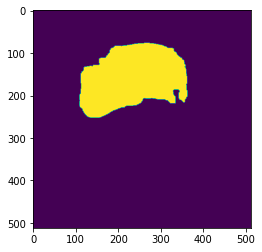

In [7]:
img1 = mpimg.imread('./Train_Sets/CT/1/Ground/liver_GT_020.png')
plt.imshow(img1)

Looks like a liver. Let's explore a bit how the data looks when we load with mpimg.imread

In [8]:
np.max(img1)

1.0

In [9]:
img1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

So, the liver is stored as 1.0 and the background as 0.0 with the data as float32 but if we load the data via other functions it will be shown to be a binary image (True or False). Let's take a look at that in the case that we open the binary PNG with Pillow's Image.open() and then convert that image to a Numpy array with np.array()

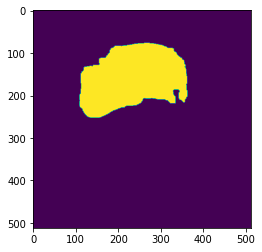

In [10]:
img2=np.array(Image.open('./Train_Sets/CT/1/Ground/liver_GT_020.png'))
plt.imshow(img2)

In [11]:
img2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Next we will get a list of the patient folders

In [12]:
labelpathct=Path('./Train_Sets/CT')
trainls=os.listdir(labelpathct)
trainls


['19',
 '26',
 '1',
 '14',
 '27',
 '24',
 '21',
 '29',
 '22',
 '2',
 '5',
 '6',
 '30',
 '25',
 '18',
 '28',
 '23',
 '10',
 '16',
 '8']

We can also then look at what the DICOMs in the CHAOS dataset look like

In [13]:
pathct='./Train_Sets/CT/1/DICOM_anon/'
ctls=os.listdir(pathct)
ctexamplefile=pathct+ctls[5]
ctex=pydicom.dcmread(ctexamplefile)

In [14]:
dcm1=ctex.pixel_array

In [15]:
huimg=pydicom.pixel_data_handlers.util.apply_modality_lut(ctex.pixel_array,ctex)

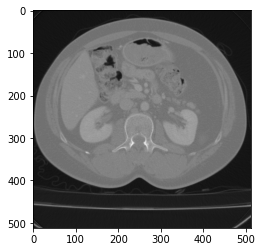

In [16]:
plt.imshow(huimg,cmap='gray')

Basically, it looks like what we expect CT data to look like

In [17]:
huimg

array([[-1029., -1027.,  -995., ..., -1005., -1022., -1015.],
       [-1014.,  -960.,  -977., ..., -1001., -1012., -1017.],
       [ -997.,  -975.,  -985., ..., -1002.,  -995., -1002.],
       ...,
       [ -947., -1007., -1057., ...,  -981.,  -968.,  -941.],
       [ -895.,  -938., -1068., ...,  -957.,  -994.,  -987.],
       [ -906.,  -898.,  -935., ...,  -953.,  -961.,  -992.]])

Now an important consideration is how we want to work with the data. An RGB PNG file will have 24 bits with 8 bits per color channel, but 8 bits is not enough to cover the range of possible HU values that we have in our CT data. We can still work with the DICOM data as PNGs if we'd like by for example, performing windowing and leveling with a narrow enough window to not lose any contrast data (e.g. selecting a window for the CT data less than 255). However, we can also work with 16 bit TIF format images to not lose any contrast resolution and not need to set a window on our CT data. Let's test this:

In [18]:
Image.fromarray(huimg).save('examplehuimg.tif') #Save an example TIF

In [19]:
i16=Image.open('examplehuimg.tif') #Open the image we saved

In [20]:
i16=np.array(i16) #Convert the PIL image to a Numpy array

In [21]:
i16

array([[-1029., -1027.,  -995., ..., -1005., -1022., -1015.],
       [-1014.,  -960.,  -977., ..., -1001., -1012., -1017.],
       [ -997.,  -975.,  -985., ..., -1002.,  -995., -1002.],
       ...,
       [ -947., -1007., -1057., ...,  -981.,  -968.,  -941.],
       [ -895.,  -938., -1068., ...,  -957.,  -994.,  -987.],
       [ -906.,  -898.,  -935., ...,  -953.,  -961.,  -992.]],
      dtype=float32)

In [22]:
i16.shape #See the dimensions of this axial slice

(512, 512)

Okay now that we have a handle on the data that we are working with, we have a few options. We can tailor some of the code related to the AI library that we are using to our dataset, or if it's feasible, like for the purposes of this tutorial, we can tailor our dataset to the code we want to use. For example, a popular dataset for AI segmentation, especially in tutorials, is CAMVID (http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/), so we might already know reasonably well how to work with a dataset formatted like that. For this tutorial, we will start by reformatting the CHAOS dataset to look a bit more like CAMVID by putting all of our DICOM axial slices, which in CHAOS are broken out into patient folders, into a single folder for our AI model to work with. We will then reformat the segmentation labels which CHAOS provides as binary PNG images into images that work with the FastAI code that we want to use. So, to do this, we will reformat the binary image PNGs as PNGs where each segmentation class that we want to have the model target is stored as an integer in an 8 bit integer format where the background has value 0 and the liver has value 1. This type of formatting will be helpful when we look at the multi-organ segmentations that CHAOS provides for MRI data in part 2 of this lesson.

Additionally, we will convert our DICOM files into 16 bit TIFs. We will also convert to windowed RGB PNGs as well so that we can compare U-net performance with different image inputs

In [23]:
#Let's set up pooled image folders for simplicity and to be similar to other datasets (CAMVID)

if not os.path.exists('./images'):
  os.mkdir('./images')
if not os.path.exists('./labels'):  
  os.mkdir('./labels')

#Make an alternate comparison
if not os.path.exists('./images2'):
  os.mkdir('./images2')


In [24]:
#The way this for loop is written is not necessarily the easiest to follow but it is not related to any actual AI modeling except to set up the dataset in a simplified way

#The basic idea is to convert the DICOMs into different image formats and modify the segmentation PNGs

#As a warning, for loops are quite slow in Python and it will take about 2-3 minutes to reformat the dataset like this.

labelpathct=Path('./Train_Sets/CT')
trainls=os.listdir(labelpathct)

for f1 in trainls:
  dcls=sorted(os.listdir(labelpathct/f1/'DICOM_anon'))
  labls=sorted(os.listdir(labelpathct/f1/'Ground'))
  for x1 in range(0,len(dcls)):
    dcpick=labelpathct/f1/'DICOM_anon'/dcls[x1]
    labpick=labelpathct/f1/'Ground'/labls[x1]
    savestem=labls[x1].split('.')[0] #Split the name from the suffix
    savenamekeep=str(f1)+'-'+savestem #Does not include character suffix
    ctex=pydicom.dcmread(dcpick) #Load the DICOM
    huimg=pydicom.pixel_data_handlers.util.apply_modality_lut(ctex.pixel_array,ctex) #Convert to HU

    Image.fromarray(huimg).save('./images/'+str(f1)+'-'+savestem+'.tif') #Save the DICOM image data as a TIF

    #Create an alternate set of images with a window and level and then turn into an RGB PNG without contrast loss on the window
    althu=huimg
    althu[althu<-100]=-100 #If we want to modify our windowing for this alternate comparison, this is where we would do it
    althu[althu>155]=155
    Image.fromarray(althu.astype('uint8')).convert('RGB').save('./images2/'+str(f1)+'-'+savestem+'.png')


    #Open the existing label image and save it in a modified format
    imtemp=np.array(Image.open(labpick))
    Image.fromarray(imtemp.astype('uint8')).convert('L').save('./labels/'+savenamekeep+'.png')




With our dataset reformatted, we are now ready to start working more directly with FastAI. We will start by setting up a DataBlock for the U-net model we intend to train. You can learn more about FastAI data blocks in the documentation: https://docs.fast.ai/data.block.html

We will be giving a few different pieces of information to our data block. We will start by setting up a paradigm of working with images for our inputs and masks for our outputs.

We will give the MaskBlock() a set of code names for the mask labels.

We will then use the get_image_files FastAI helper function for getting the items from our image folder.

We will also have to define how we want to split our data into a training and validation dataset. For the purposes of this tutorial, we will use EndSplitter and use the last 25% of the set of images for validation. However, for a research project, we would likely want to use a different approach and split our training and validationd datasets at the patient level. Data splitting options within FastAI are also further discussed in the FastAI documentation: https://docs.fast.ai/data.transforms.html

Next we will define how to get the mask data. We will do this by defining a lamdba function (an anonymous function) that will match our input image name to the corresponding label name. We perform this matching with f-string formatting

Finally, we define our transforms which will include data resizing of the input images and normalization of the image statistics. We will resize our images to smaller dimensions in order to be able to train our U-nets faster. Reducing image size can also be advantageous when it allows us to simultaneously increase the batch size. 

In [25]:
codes=['Default','Liver']
basesz=(512,512)
lilsz=(128,128)
medsz=(256,256)

In [26]:
dblock = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   splitter = EndSplitter(valid_pct=0.25, valid_last=True), #GrandparentSplitter more appropriate for research
                   get_y = lambda rx: './labels/'+f'{rx.stem}.png', #Use f string and lambda since we have different file suffix for lable imagese
                   batch_tfms=[*aug_transforms(size=medsz),Normalize.from_stats(*imagenet_stats)]
                   )



In [27]:
dls=dblock.dataloaders('./images',bs=8,path='.') #Here we define the path to where the images are, our batch size, and our path

#We can change './images' to './images2 if we want to see how a model might work with the windowed PNGs instead of the TIFs



/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


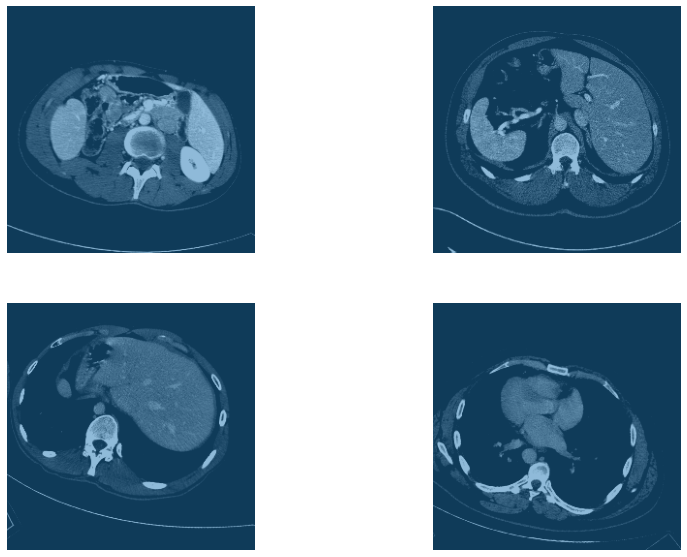

In [28]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10)) 
#We can show a batch but the way that we have formatted our segmentation labels will make it difficult to see the segmentation overaly

In [29]:
#We can also inspect what an item in the batch looks like

x1, y1=dls.one_batch()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [30]:
x1.shape

torch.Size([8, 3, 256, 256])

In [31]:
y1.shape

torch.Size([8, 256, 256])

In [32]:
#We can define a custom function to assess the accuracy of our model, but as we see once we start training, this is not an optimal way to assess performance
#Accuracy is not an optimal way to track performance since the data is predominantly background rather than liver

def acc_1(inp, targ):
  targ = targ.squeeze(1)
  return (inp.argmax(dim=1)==targ).float().mean()

Okay, after setting up our data block and dataloaders with FastAI we our ready to start training our U-net. This is as easy as a single line in FastAI. 

In [33]:

learn = unet_learner(dls, resnet34, metrics=[Dice(),JaccardCoeff(),acc_1], self_attention=True)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

So, we have used as inputs the data loader that we set up and a model architecture for a pretrained model to use as the backbone for the U-net (ResNet34).

We have also set up 3 metrics, which are Dice coefficient, Jaccard coefficient, and accuracy. These metrics will be used to track how our model is doing during training, but they are not loss functions so they will not impact the training itself.

We also have set self-attention as True, although it is False by default. The concept of self-attention in U-nets has been explored in the following work by Petit et al.: https://arxiv.org/abs/2103.06104

Empirically, self-attention does not necessarily have a very large impact on peformance for this tutorial, so you can experiment with setting this as True or False and running the model under different conditions

When we set up our U-net, we did not explicitly define an optimizer or loss function. We will explore more details about these concepts in Lesson 4 but let us see what defaults we are using.

In [34]:
learn.opt_func

<function fastai.optimizer.Adam>

The default Adam optimizer works well. We can try changing this to ranger, though or SGD if we want to compare different optimizers. 

In [35]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Our default loss function is a flattened version of cross entropy loss

In [36]:
#We can also print a detailed model summary

learn.summary()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


DynamicUnet (Input shape: 8 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 128 x 128  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 64 x 64    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

Now for the moment of truth, we are going to actually start training a U-net model. We are going to pick our learning rate in advance and explore more how to pick a learning rate in Lesson 4.

We will train our U-net model for 10 epochs which means that it will essentially look at the training data 10 times.

We can also observe how our 3 metrics change with each epoch. The Dice coefficient will always be greater than or equal to the Jaccard coefficient. 

With 256x256 size input images, it will take approximately 2 minutes to complete each epoch of training. We can experiment with training for more epochs by modifying the first input into the fit_one_cycle method

Since we are training for 10 epochs and it takes approximately 2 minutes to train each epoch, training our U-net will take about 20 minutes. Our Dice coefficient after 10 epochs will be about 0.981 for this dataset, but after 3 epochs it will be about 0.97. So, if you don't want to wait but still want to finish the lesson, then you can reduce the number of training epochs. Alternatively, take a 20 minute break while the U-net trains. If using Colab, though, then be careful that you can disconnect after a time out on the session and lose progress in your notebook.

In [37]:
lr1 = 1e-3
learn.fit_one_cycle(10,slice(lr1))

epoch,train_loss,valid_loss,dice,jaccard_coeff,acc_1,time
0,0.026220,0.021930,0.943689,0.893382,0.992580,01:23
1,0.027760,0.017875,0.952966,0.910157,0.993931,01:21
2,0.012725,0.011935,0.965414,0.933140,0.995479,01:21
3,0.011673,0.010413,0.970651,0.942976,0.996243,01:21
4,0.008728,0.019421,0.952414,0.909151,0.994078,01:22
5,0.007213,0.009664,0.972170,0.945846,0.996459,01:22
6,0.006377,0.006085,0.980586,0.961912,0.997524,01:22
7,0.006248,0.006011,0.980519,0.961783,0.997521,01:22
8,0.006348,0.005587,0.981952,0.964544,0.997693,01:21
9,0.005538,0.005527,0.982151,0.964928,0.997718,01:21


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [38]:
learn.save('basicR34-Unet-10epochs-CT-256x256') #We can save our model like this and then load it again later.
#This model will be saved in a models folder

Path('models/basicR34-Unet-10epochs-CT-256x256.pth')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


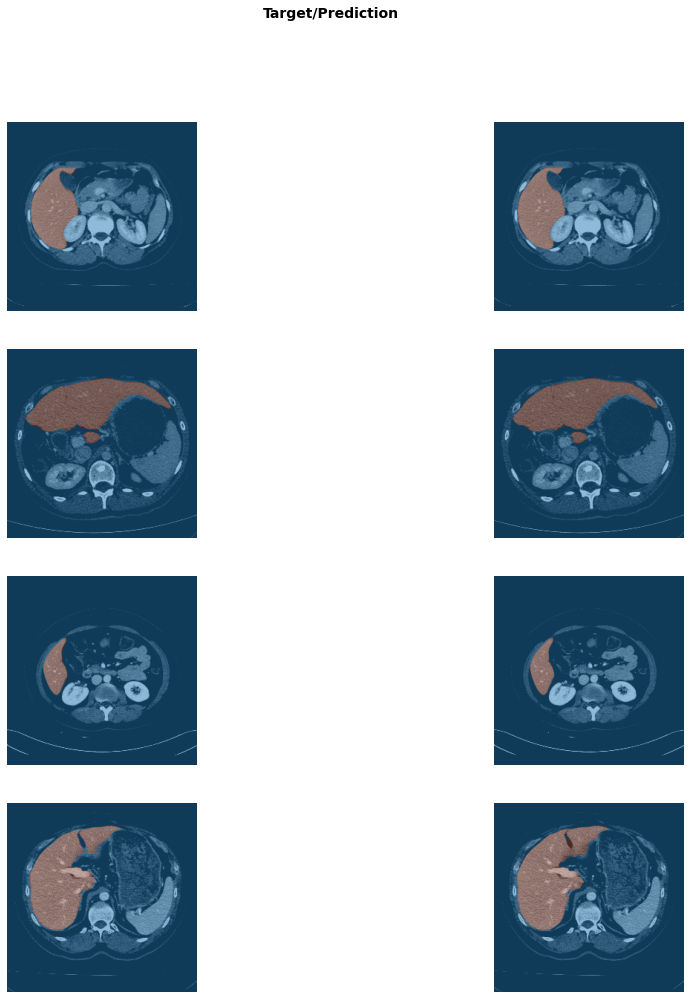

In [39]:
#We can look at several our results at once
learn.show_results(max_n=4, figsize=(16,16))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


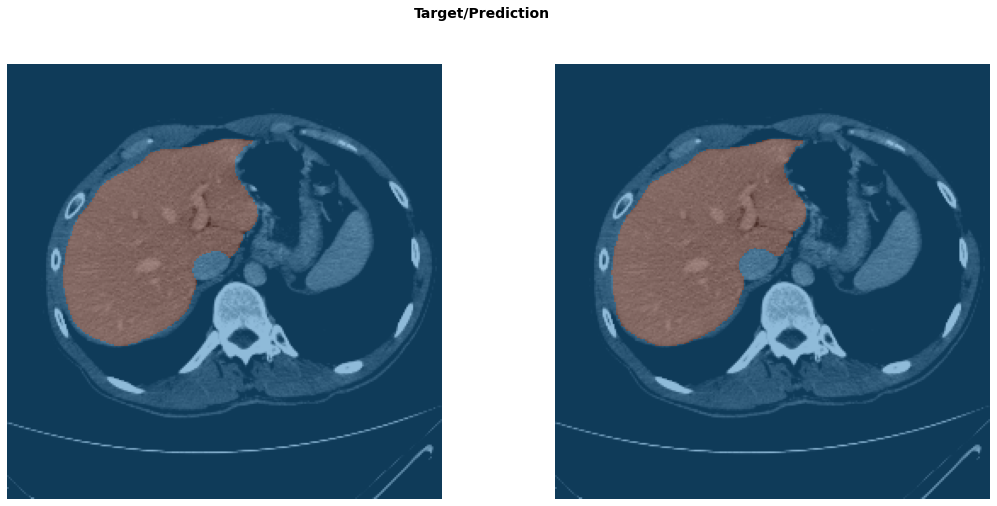

In [40]:
#We can also focus on one set of ground truth and predictions at a time by expecting it closely and re-running this cell

#What issues do you see? One potential issue is that some of the predictions might include portions of the IVC

learn.show_results(max_n=1, figsize=(18,8))

Next we will use the SegmentationInterpretation class in FastAI to visualize the example images for which our model had the worst performance (highest value of the loss function). This is a great way to visualize potential issues with the model or dataset. 

In [41]:
interp = SegmentationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


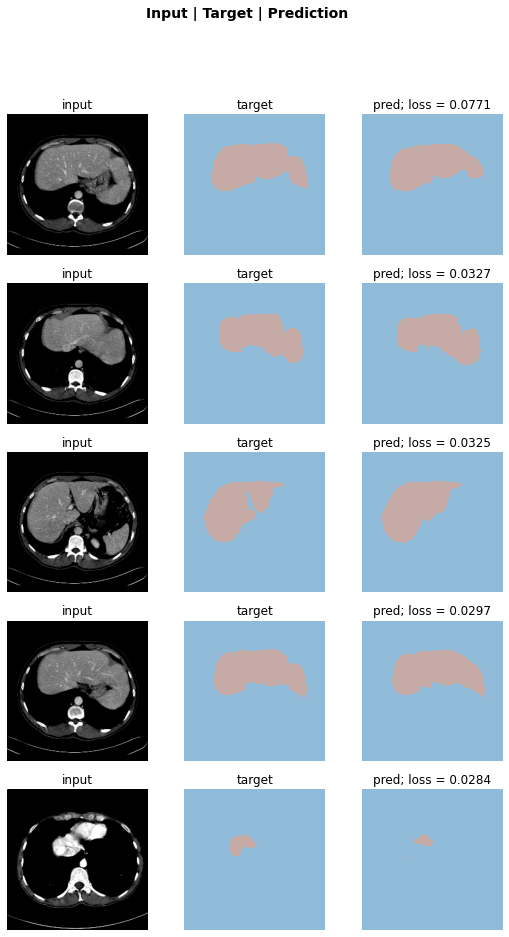

In [42]:
interp.plot_top_losses(5)

With a trained model which has reasonable appearing performance metrics and visually reasonable predictions for our training and validation datasets, our next step will be to use a test dataset to further investigate model predictions. We will do this in the second part of lesson 2, after we build a second model to work with MRI data.